Alkım Ege Akarsu | 21901461 | EEE 485 | Term Project
# Classification of Diabetic and Non-Diabetic Individuals Based on Survey Data
# Logistic Regression
## Package Imports

In [1]:
import numpy as np  # For math operations
import pandas as pd  # For importing and handling datasets
import matplotlib.pyplot as plt  # For plotting
from mpl_toolkits.mplot3d import axes3d  # For 3D component of plotting

# Pandas options
pd.set_option("display.max_columns", None)

## Functions

In [2]:
# DATASET PREPARATION
def train_test_split(dataset, train_fraction):
    """Split the dataset into train and test sets

    Args:
        dataset (DataFrame): All available data points.
        Label and features as columns, Datapoints as rows.
        train_fraction (float): Fraction of data
        points to be added to the training set.

    Returns:
        DataFrame: Training dataset
        DataFrame: Test dataset
    """
    # Randomly sample for train
    train = dataset.sample(frac=train_fraction, axis="index")
    # Subtract train from original
    test = dataset.drop(index=train.index)
    # Reset indexes
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)

    return train, test


def balance_dataset(dataset):
    """Returns a dataset with equal members of each class. Takes all
    data points of the less represented class.

    Args:
        dataset (DataFrame): Original dataset. Has shape (n, p).

    Returns:
        DataFrame: Balanced dataset. Has shape (_, p).
    """
    # Determine the less and more represented classes
    label_counts = dataset["Diabetes"].value_counts()
    least_frequent_class = label_counts.idxmin()
    most_frequent_class = label_counts.idxmax()
    # Get all data points of the less represented class
    least_frequent_class_data = dataset[dataset["Diabetes"] == least_frequent_class]
    # Get equal number of data points of the most represented class
    most_frequent_class_data = dataset[
        dataset["Diabetes"] == most_frequent_class
    ].sample(len(least_frequent_class_data.index))
    # Combine and shuffle the DataFrames to get the result
    result = pd.concat([least_frequent_class_data, most_frequent_class_data])
    result = result.sample(frac=1).reset_index(drop=True)

    return result


def standardize(train, test):
    """Standardize X matrices of train and test splits. Uses the mean and
    standard deviation of the training set to standardize both training
    and test sets. This prevents data leakage between training and test sets.

    Args:
        train (DataFrame): Training set.
        test (DataFrame): Test set.

    Returns:
        DataFrame: Standardized training set
        DataFrame: Standardized test set
    """
    # Get mean and standard deviation
    mean = train.mean()
    std = train.std()
    # Get results
    train_result = (train - mean) / std
    test_result = (test - mean) / std

    return train_result, test_result


# LOGISTIC REGRESSION
def initialize(X):
    """Initialize the parameters and the design matrix.

    Args:
        X (DataFrame): Design matrix

    Returns:
        ndarray: Design matrix with bias column
        ndarray: Randomly initialized parameter vector.
        Has shape (Parameter count + 1 (bias term), 1 ).
    """
    # Initialize parameters
    # Parameter count + 1 (bias term) rows, 1 column
    parameters = np.random.randn(X.shape[1] + 1, 1)
    # Add a column of ones to the beginning of the design matrix
    X_logistic = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    return X_logistic, parameters


def sigmoid(X, parameters):
    """Prediction values between 0 and 1 using the sigmoid function.

    Args:
        X (ndarray): Design matrix. Has shape (n, p + 1)
        parameters (ndarray): Parameter vector (weights). Has shape (p + 1, 1)

    Returns:
        ndarray: A prediction for every data point in the design matrix.
        Has shape (n, 1)
    """
    sigmoid = 1 / (1 + np.exp(-np.dot(X, parameters)))

    return sigmoid


def get_cost(X, y, parameters, lambda_reg):
    """L1 regularized log loss

    Args:
        X (ndarray): Design matrix. Has shape (n, p + 1)
        y (ndarray): Label vector. Has shape (n, 1)
        parameters (ndarray): Parameter vector (weights). Has shape (p + 1, 1)
        lambda_reg (double): L1 Regularization parameter

    Returns:
        double: L1 regularized log loss of the dataset
    """
    # Log loss + L1 regularization
    # h is the prediction
    h = sigmoid(X, parameters)
    # Log loss
    log_loss = -(y * np.log(h) + (1 - y) * np.log(1 - h)).mean()
    # L1 regularization (exclude bias term)
    regularization = lambda_reg * np.sum(np.abs(parameters[1:]))

    return log_loss + regularization


def train(
    X_train,
    y_train,
    X_test,
    y_test,
    parameters,
    learning_rate,
    iterations,
    lambda_reg,
    test=False,
):
    """Train the logistic regression model using gradient descent

    Args:
        X_train (ndarray): Design matrix. Has shape (n, p + 1)
        y_train (ndarray): Label vector. Has shape (n, 1)
        X_test (ndarray): Design matrix. Has shape (t, p + 1)
        y_test (ndarray): Label vector. Has shape (t, 1)
        parameters (ndarray): Parameter vector (weights). Has shape (p + 1, 1)
        learning_rate (double): Gradient descent learning rate
        iterations (int): How many steps to take in gradient descent
        lambda_reg (double): L1 Regularization parameter
        test (bool): Get costs on the test set after each iteration

    Returns:
        ndarray: Trained parameter vector (weights). Has shape (p + 1, 1)
        ndarray: Training costs for each epoch. Has shape (iterations,)
        ndarray: Test costs for each epoch. Has shape (iterations,)
    """
    # Initialize array of costs over time to return
    costs_train = np.zeros(iterations)
    costs_test = np.zeros(iterations)
    # Initialize copy of original parameters
    new_parameters = parameters.copy()
    # Start gradient descent
    for i in range(iterations):
        # h is the prediction
        h = sigmoid(X_train, new_parameters)
        # Gradient of log loss
        gradient_log = np.dot(X_train.T, (h - y_train)) / y_train.shape[0]
        # Gradient of L1 regularization (exclude bias term)
        gradient_L1_reg = np.concatenate(
            ([0], lambda_reg * np.sign(new_parameters[1:].squeeze()))
        )
        gradient_L1_reg = gradient_L1_reg.reshape(-1, 1)
        # Total gradient
        gradient = gradient_log + gradient_L1_reg
        # New parameters
        new_parameters -= learning_rate * gradient
        # Add new cost to cost list
        costs_train[i] = get_cost(X_train, y_train, new_parameters, lambda_reg)
        if test == True:
            costs_test[i] = get_cost(X_test, y_test, new_parameters, lambda_reg)
        # Print latest cost occasionally
        if i % 10 == 0:
            print(f"Iteration: {i}\n" f"Cost: {costs_train[i]}\n")
    # Print final cost
    print(f"\nFinal Cost: {costs_train[-1]}\n")

    return new_parameters, costs_train, costs_test


# MODEL EVALUATION
def predict(X, parameters, threshold):
    """Predict labels using trained parameters.

    Args:
        X (ndarray): Feature values for each data point. Has shape (t, p + 1)
        parameters (ndarray): Trained parameter vector (weights).
        Has shape (p + 1, 1)
        threshold (double): Threshold determining class of data point.
        0 if under and 1 if over.

    Returns:
        ndarray: Predicted labels of all data points. Has shape (t, 1)
    """
    probabilities = sigmoid(X, parameters)
    predictions = probabilities >= threshold
    predictions = predictions.astype(np.uint8)

    return predictions


def get_confusion_matrix(true, pred):
    """Calculate confusion matrix for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        ndarray: Confusion matrix
        TN FP
        FN TP
    """
    result = np.zeros((2, 2))

    for i in range(true.shape[0]):
        result[true[i][0]][pred[i][0]] += 1

    return result


def get_accuracy(true, pred):
    """Calculate accuracy for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: Accuracy value.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return (TP + TN) / (TP + TN + FP + FN)


def get_precision(true, pred):
    """Calculate precision for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: Precision value.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return TP / (TP + FP)


def get_recall(true, pred):
    """Calculate recall for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: Recall value.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return TP / (TP + FN)


def get_f1_score(true, pred):
    """Calculate F1 score for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: F1 score.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return (2 * TP) / ((2 * TP) + FP + FN)


# HYPERPARAMETER TUNING
def cross_validation(
    X_train,
    y_train,
    X_test,  # Don't use
    y_test,  # Don't use
    parameters,  # Initialized parameter vector
    learning_rate,
    iterations,
    lambda_reg,
    K,
    threshold,
):
    """Evaluate model performance using K-fold cross-validation.

    Args:
        X_train (ndarray): Design matrix. Has shape (n, p + 1)
        y_train (ndarray): Label vector. Has shape (n, 1)
        X_test (ndarray): Design matrix. Has shape (t, p + 1) (Not used)
        y_test (ndarray): Label vector. Has shape (t, 1) (Not used)
        parameters (ndarray): Parameter vector (weights). Has shape (p + 1, 1)
        learning_rate (double): Gradient descent learning rate
        iterations (int): How many steps to take in gradient descent
        lambda_reg (double): L1 Regularization parameter
        K (int): Number of folds
        threshold (double): Threshold determining class of data point.

    Returns:
        double: Mean F1 score of all K folds
    """
    # Initialize f1 score storage
    f1_scores = np.zeros(K)
    # Split dataset into k folds
    X_folds = np.array_split(X_train, K)
    y_folds = np.array_split(y_train, K)
    # Loop over folds
    for i in range(K):
        # Get validation set
        X_validation_set = X_folds[i]
        y_validation_set = y_folds[i]
        # Get training set (list comprehension ftw)
        X_training_set = np.concatenate([X_folds[j] for j in range(K) if j != i])
        y_training_set = np.concatenate([y_folds[j] for j in range(K) if j != i])
        # Train model on training set
        trained_parameters, _, _ = train(
            X_training_set,
            y_training_set,
            X_test,  # Don't use
            y_test,  # Don't use
            parameters,  # Initialized parameter vector
            learning_rate,
            iterations,
            lambda_reg,
        )
        # Validate model on validation set
        predictions = predict(X_validation_set, trained_parameters, threshold)
        f1_score = get_f1_score(y_validation_set, predictions)
        # Save F1 score
        f1_scores[i] = f1_score
    # Return average F1 score
    return f1_scores.mean()


def tune_hyperparameters(
    X_train,
    y_train,
    X_test,
    y_test,
    parameters,
    learning_rate,
    iterations,
    lambda_reg_values,
    threshold_values,
    K,
):
    """Try to find the best lambda_reg and threshold values using
    grid search and K-fold cross validation.

    Args:
        X_train (ndarray): Design matrix. Has shape (n, p + 1)
        y_train (ndarray): Label vector. Has shape (n, 1)
        X_test (ndarray): Design matrix. Has shape (t, p + 1) (Not used)
        y_test (ndarray): Label vector. Has shape (t, 1) (Not used)
        parameters (ndarray): Parameter vector (weights). Has shape (p + 1, 1)
        learning_rate (double): Gradient descent learning rate
        iterations (int): How many steps to take in gradient descent
        lambda_reg_values (ndarray): L1 Regularization parameters to try
        threshold_values (ndarray): Threshold values to try
        K (int): Number of folds

    Returns:
        double: Tuned lambda_reg value
        double: Tuned threshold value
    """
    # Initialize results matrix
    # 3 columns: lambda_reg, threshold, score
    results = np.empty((0, 3))

    # Perform grid search
    # Loop over lambda_reg_values
    for lambda_reg in lambda_reg_values:
        # Loop over threshold_values
        for threshold in threshold_values:
            # Perform cross-validation
            f1_score = cross_validation(
                X_train,
                y_train,
                X_test,
                y_test,
                parameters,
                learning_rate,
                iterations,
                lambda_reg,
                K,
                threshold,
            )
            # Append lambda_reg, threshold, f1_score row to results matrix
            row = np.array([lambda_reg, threshold, f1_score])
            results = np.vstack((results, row))

    lambda_reg_results = results[:, 0].flatten()
    threshold_results = results[:, 1].flatten()
    f1_score_results = results[:, 2].flatten()
    # Plot scores against lambda_reg values
    plt.plot(lambda_reg_results, f1_score_results, ".")
    plt.title("F1 Score vs L1 Regularization Lambda")
    plt.xlabel("L1 Regularization Lambda")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()
    # Plot scores against threshold values
    plt.plot(threshold_results, f1_score_results, ".")
    plt.title("F1 Score vs Decision Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()
    # Plot scores against lambda_reg values against threshold values
    plt.clf()
    ax = plt.figure().add_subplot(projection="3d")
    # Plot the 3D surface
    ax.plot_trisurf(
        lambda_reg_results,
        threshold_results,
        f1_score_results,
        edgecolor="royalblue",
        lw=0.5,
        alpha=0.3,
    )
    ax.set(
        xlabel="L1 Regularization Lambda",
        ylabel="Decision Threshold",
        zlabel="F1 Score",
    )
    plt.title("F1 Score vs L1 Regularization Lambda vs Decision Threshold")
    plt.show()

    # Get best_lambda_reg, best_threshold pair
    # Row index of max score
    row_index = np.argmax(results[:, 2])
    best_row = results[row_index]
    best_lambda_reg = best_row[0]
    best_threshold = best_row[1]

    return best_lambda_reg, best_threshold

## Dataset Preparation

In [3]:
# Import dataset into a pandas dataframe
# Data points classified as "diabetes or pre-diabetes"(1) or "no diabetes"(0)
dataset = pd.read_csv("datasets/binary.csv", dtype="uint8")
# Dataset overview
dataset.info(verbose=True, show_counts=True)

# Divide dataset into training and test sets
train_fraction = 0.8
training, test = train_test_split(dataset, train_fraction)
# Create a balanced training set
training_balanced = balance_dataset(training)
# Number of data points
print(f"\n\nNumber of data points in train set: {len(training.index)}")
print(f"Number of data points in balanced train set: {len(training_balanced.index)}")
print(f"Number of data points in test set: {len(test.index)}")

# Get X and Y from train, balanced_train, and test datasets
# Train
y_train = training["Diabetes"]
X_train = training.drop("Diabetes", axis=1)
# Balanced train
y_balanced_train = training_balanced["Diabetes"]
X_balanced_train = training_balanced.drop("Diabetes", axis=1)
# Test
y_test = test["Diabetes"]
X_test = test.drop("Diabetes", axis=1)

# Standardize Xs
X_train_standardized, X_test_standardized = standardize(X_train, X_test)
X_balanced_train_standardized, X_balanced_test_standardized = standardize(
    X_balanced_train, X_test
)

# Convert everything from dataframe to ndarray and reshape
# Train
X_train_standardized = X_train_standardized.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
# Balanced train
X_balanced_train_standardized = X_balanced_train_standardized.to_numpy()
y_balanced_train = y_balanced_train.to_numpy().reshape(-1, 1)
# Test
X_test_standardized = X_test_standardized.to_numpy()
y_test = y_test.to_numpy().reshape(-1, 1)
# Balanced test
X_balanced_test_standardized = X_balanced_test_standardized.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes              253680 non-null  uint8
 1   HighBP                253680 non-null  uint8
 2   HighChol              253680 non-null  uint8
 3   CholCheck             253680 non-null  uint8
 4   BMI                   253680 non-null  uint8
 5   Smoker                253680 non-null  uint8
 6   Stroke                253680 non-null  uint8
 7   HeartDiseaseorAttack  253680 non-null  uint8
 8   PhysActivity          253680 non-null  uint8
 9   Fruits                253680 non-null  uint8
 10  Veggies               253680 non-null  uint8
 11  HvyAlcoholConsump     253680 non-null  uint8
 12  AnyHealthcare         253680 non-null  uint8
 13  NoDocbcCost           253680 non-null  uint8
 14  GenHlth               253680 non-null  uint8
 15  MentHlth              253680 non-n

## Hyperparameter Tuning
### Balanced Training Set

Iteration: 0
Cost: 2.2275097652150277

Iteration: 10
Cost: 0.7388694031795192

Iteration: 20
Cost: 0.5466356812874098

Iteration: 30
Cost: 0.5169353612851002

Iteration: 40
Cost: 0.5130989405949138


Final Cost: 0.5125051182706828

Iteration: 0
Cost: 2.2217368183220367

Iteration: 10
Cost: 0.7399861344800873

Iteration: 20
Cost: 0.5471795326012948

Iteration: 30
Cost: 0.5174608651599645

Iteration: 40
Cost: 0.5136592453815302


Final Cost: 0.5130766559023755

Iteration: 0
Cost: 2.2262801097041347

Iteration: 10
Cost: 0.74150037999084

Iteration: 20
Cost: 0.548528047915421

Iteration: 30
Cost: 0.5189953296753377

Iteration: 40
Cost: 0.5152177680621132


Final Cost: 0.5146367785786304

Iteration: 0
Cost: 2.2272992513640317

Iteration: 10
Cost: 0.7400861273149943

Iteration: 20
Cost: 0.5476459352925996

Iteration: 30
Cost: 0.5181264005881978

Iteration: 40
Cost: 0.5143528524423256


Final Cost: 0.5137750061946856

Iteration: 0
Cost: 2.227324729308724

Iteration: 10
Cost: 0.741692785459208

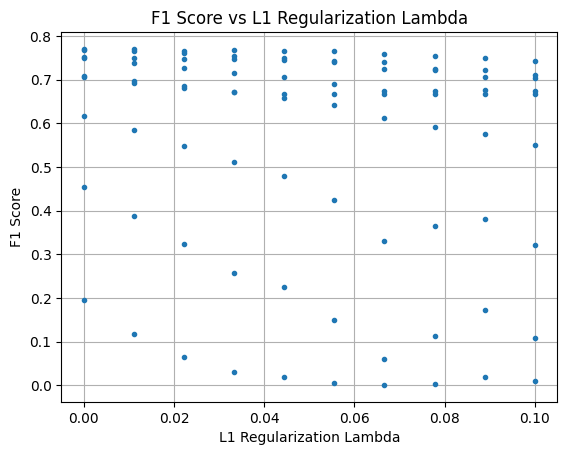

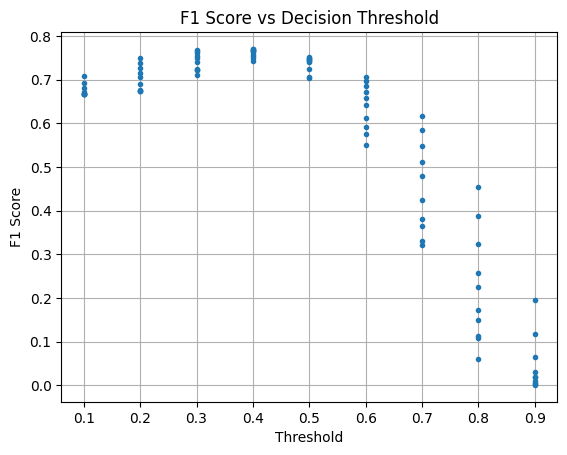

<Figure size 640x480 with 0 Axes>

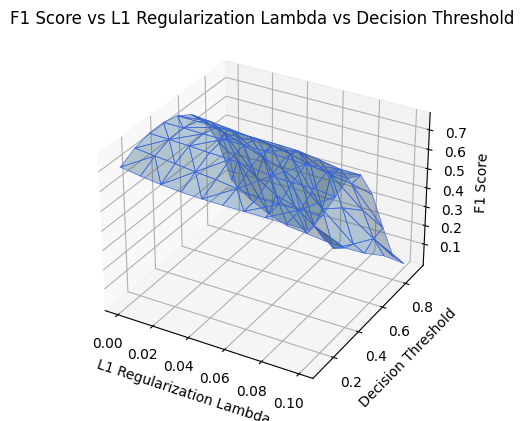

Best lambda_reg, threshold combination: 0.0, 0.4


In [4]:
# Initialize necessary variables
X_balanced_train_logistic, parameters_balanced_logistic = initialize(
    X_balanced_train_standardized
)
X_balanced_test_logistic, _ = initialize(X_balanced_test_standardized)

# Get best hyperparameters (lambda and threshold)
learning_rate = 1
iterations = 50
K = 10
lamda_reg_values = np.linspace(0, 0.1, 10)
threshold_values = np.arange(0.1, 1.0, 0.1)  # 0.1, 0.2, ..., 0.8, 0.9
lambda_reg_balanced, threshold_balanced = tune_hyperparameters(
    X_balanced_train_logistic,
    y_balanced_train,
    X_balanced_test_logistic,
    y_test,
    parameters_balanced_logistic,
    learning_rate,
    iterations,
    lamda_reg_values,
    threshold_values,
    K,
)

# Print the results
print(
    f"Best lambda_reg, threshold combination: {lambda_reg_balanced}, {threshold_balanced}"
)

### Imbalanced Training Set

Iteration: 0
Cost: 1.1907338545714035

Iteration: 10
Cost: 0.493283785450075

Iteration: 20
Cost: 0.37353557611489496

Iteration: 30
Cost: 0.34417395568130854

Iteration: 40
Cost: 0.3325715433586163


Final Cost: 0.3273601583544121

Iteration: 0
Cost: 1.1894159688964845

Iteration: 10
Cost: 0.49288294899062857

Iteration: 20
Cost: 0.3729740300142378

Iteration: 30
Cost: 0.3436535352786951

Iteration: 40
Cost: 0.33211171229850056


Final Cost: 0.32692909585304764

Iteration: 0
Cost: 1.1897741252312317

Iteration: 10
Cost: 0.4924494545801808

Iteration: 20
Cost: 0.3730999150926217

Iteration: 30
Cost: 0.3437376959591175

Iteration: 40
Cost: 0.33217407680150784


Final Cost: 0.3270032192609414

Iteration: 0
Cost: 1.1903750006411715

Iteration: 10
Cost: 0.49179100278140514

Iteration: 20
Cost: 0.3725427180922115

Iteration: 30
Cost: 0.3432676185293652

Iteration: 40
Cost: 0.3317152452007788


Final Cost: 0.32653141775306516

Iteration: 0
Cost: 1.1896820900183627

Iteration: 10
Cost: 0.4926

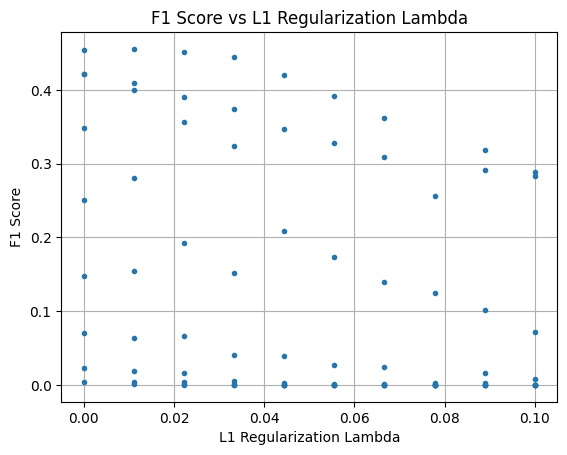

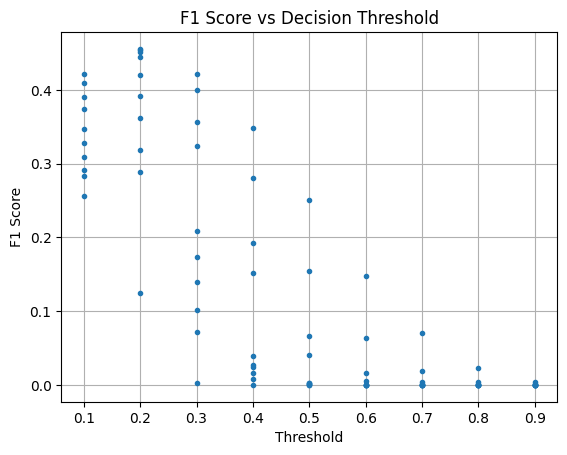

<Figure size 640x480 with 0 Axes>

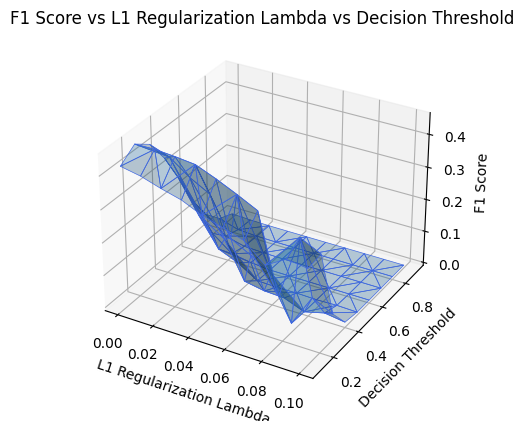

Best lambda_reg, threshold combination: 0.011111111111111112, 0.2


In [5]:
# Initialize necessary variables
X_train_logistic, parameters_logistic = initialize(X_train_standardized)
X_test_logistic, _ = initialize(X_test_standardized)

# Get best hyperparameters (lambda and threshold)
learning_rate = 1
iterations = 50
K = 10
lamda_reg_values = np.linspace(0, 0.1, 10)
threshold_values = np.arange(0.1, 1.0, 0.1)  # 0.1, 0.2, ..., 0.8, 0.9
lambda_reg, threshold = tune_hyperparameters(
    X_train_logistic,
    y_train,
    X_test_logistic,
    y_test,
    parameters_logistic,
    learning_rate,
    iterations,
    lamda_reg_values,
    threshold_values,
    K
)

# Print the results
print(f"Best lambda_reg, threshold combination: {lambda_reg}, {threshold}")

## Final Models and Results
### Balanced Training Set

Iteration: 0
Cost: 1.54793004527248

Iteration: 10
Cost: 0.7605615193017986

Iteration: 20
Cost: 0.5564773100507525

Iteration: 30
Cost: 0.5206594571321036

Iteration: 40
Cost: 0.5151879273546395


Final Cost: 0.5141509123185666



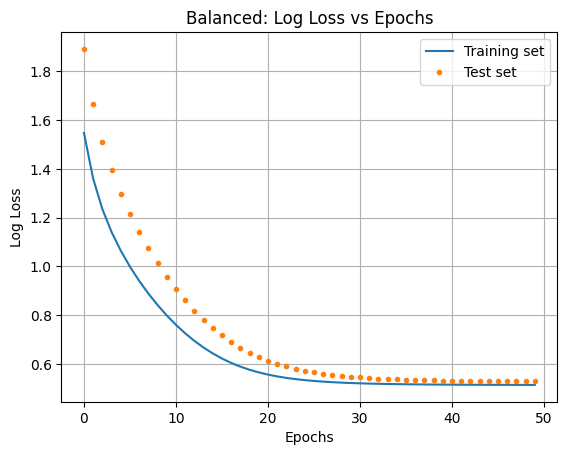

Accuracy: 0.6636116367076632
F1-score: 0.41489252288388356
TN, FP, TP, FN: 27618.0, 16031.0, 6051.0, 1036.0



In [6]:
# Initialize necessary variables
X_balanced_train_logistic, parameters_balanced_logistic = initialize(
    X_balanced_train_standardized
)
X_balanced_test_logistic, _ = initialize(X_balanced_test_standardized)

# Train logistic model
learning_rate = 1
iterations = 50
(
    parameters_balanced_logistic,
    costs_balanced_train_logistic,
    costs_balanced_test_logistic,
) = train(
    X_balanced_train_logistic,
    y_balanced_train,
    X_balanced_test_logistic,
    y_test,
    parameters_balanced_logistic,
    learning_rate,
    iterations,
    lambda_reg=lambda_reg_balanced,
    test=True,
)

# Plot loss functions over time
plt.plot(costs_balanced_train_logistic, label="Training set")
plt.plot(costs_balanced_test_logistic, ".", label="Test set")
plt.title("Balanced: Log Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()
plt.grid(True)
plt.show()

# Get evaluation metrics on test set
predictions = predict(
    X_balanced_test_logistic, parameters_balanced_logistic, threshold=threshold_balanced
)
trained_accuracy = get_accuracy(y_test, predictions)
trained_confusion_matrix = get_confusion_matrix(y_test, predictions)
trained_f1_score = get_f1_score(y_test, predictions)
TN, FP, FN, TP = get_confusion_matrix(y_test, predictions).ravel()
print(
    f"Accuracy: {trained_accuracy}\n"
    f"F1-score: {trained_f1_score}\n"
    f"TN, FP, TP, FN: {TN}, {FP}, {TP}, {FN}\n"
)

### Imbalanced Training Set

Iteration: 0
Cost: 3.172172886224412

Iteration: 10
Cost: 0.5711881750841734

Iteration: 20
Cost: 0.3689394279245119

Iteration: 30
Cost: 0.35300414277996256

Iteration: 40
Cost: 0.3493333845882979


Final Cost: 0.3471455084741234



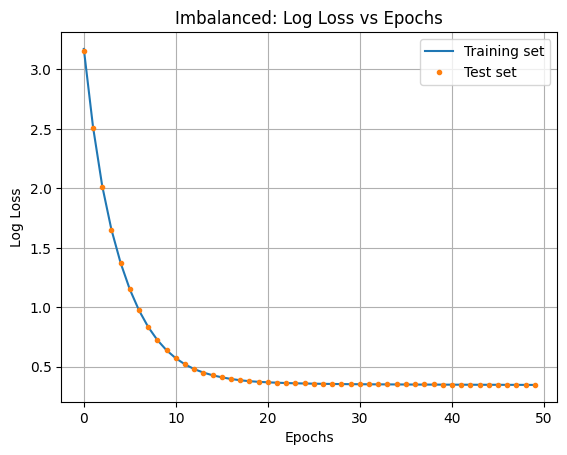

Accuracy: 0.7961999369284137
F1-score: 0.4589786521557137
TN, FP, TP, FN: 36010.0, 7639.0, 4386.0, 2701.0



In [7]:
# Initialize necessary variables
X_train_logistic, parameters_logistic = initialize(X_train_standardized)
X_test_logistic, _ = initialize(X_test_standardized)

# Train logistic model
learning_rate = 1
iterations = 50
parameters_logistic, costs_train_logistic, costs_test_logistic = train(
    X_train_logistic,
    y_train,
    X_test_logistic,
    y_test,
    parameters_logistic,
    learning_rate,
    iterations,
    lambda_reg=lambda_reg,
    test=True,
)

# Plot loss functions over time
plt.plot(costs_train_logistic, label="Training set")
plt.plot(costs_test_logistic, ".", label="Test set")
plt.title("Imbalanced: Log Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()
plt.grid(True)
plt.show()

# Get evaluation metrics on test set
predictions = predict(X_test_logistic, parameters_logistic, threshold=threshold)
trained_accuracy = get_accuracy(y_test, predictions)
trained_confusion_matrix = get_confusion_matrix(y_test, predictions)
trained_f1_score = get_f1_score(y_test, predictions)
TN, FP, FN, TP = get_confusion_matrix(y_test, predictions).ravel()
print(
    f"Accuracy: {trained_accuracy}\n"
    f"F1-score: {trained_f1_score}\n"
    f"TN, FP, TP, FN: {TN}, {FP}, {TP}, {FN}\n"
)